In [7]:
from torchvision.transforms import transforms
from torchvision.transforms import ToPILImage

import torch
import torchvision as tv

show = ToPILImage()

In [ ]:
import os

data_save_path = os.path.abspath('.') + '\\data'
# print(data_save_path)

In [8]:
# 数据预处理
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

# 训练集
train_dataset = tv.datasets.CIFAR10(root=data_save_path,
                                    train=True,
                                    transform=transform,
                                    download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=4,
                                               shuffle=True)

# 测试集
test_dataset = tv.datasets.CIFAR10(root=data_save_path,
                                   train=False,
                                   download=True,
                                   transform=transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=4,
                                              shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting E:\PY_PROJECTS\NLP_Learning\pytorch-basic\chapter01-quickstart\data\cifar-10-python.tar.gz to E:\PY_PROJECTS\NLP_Learning\pytorch-basic\chapter01-quickstart\data
Files already downloaded and verified


frog


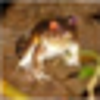

In [10]:
data, label = train_dataset[0]
print(classes[label])
# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

       frog         car        ship         car


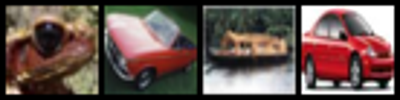

In [11]:
train_iter = iter(train_dataloader)
images, labels = train_iter.__next__()
print(' '.join('%11s' % classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images + 1) / 2)).resize((400, 100))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
torch.set_num_threads(8)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

for epoch in range(2):
    total_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 梯度清零
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5s] loss: %.3f' % (epoch + 1, i + 1, total_loss / 2000))
            total_loss = 0.0
print('train finished')

[1,  2000] loss: 1.175
[1,  4000] loss: 1.185
[1,  6000] loss: 1.172
[1,  8000] loss: 1.145
[1, 10000] loss: 1.160
[1, 12000] loss: 1.137
[2,  2000] loss: 1.068
[2,  4000] loss: 1.083
[2,  6000] loss: 1.068
[2,  8000] loss: 1.089
[2, 10000] loss: 1.089
[2, 12000] loss: 1.072
train finished


实际的label:       cat     ship     ship    plane


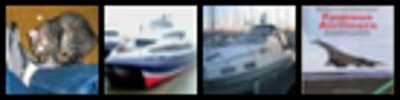

In [15]:
test_iter = iter(test_dataloader)
images, labels = test_iter.__next__()
print('实际的label: ', ' '.join('%8s' % classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images + 1) / 2)).resize((400, 100))

In [17]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs.data, 1)
print('预测结果: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

预测结果:    cat  ship  ship  ship


In [21]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        labels = labels.to(device)
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张的准确率: %d %%' % (100 * correct / total))

10000张的准确率: 60 %
